In [90]:
import math
import numpy as np
from scipy import interpolate
import cv2
import random
from matplotlib import pyplot as plt
%matplotlib inline

In [91]:
def hessian(x):
    """
    Calculate the hessian matrix with finite differences
    Parameters:
       - x : ndarray
    Returns:
       an array of shape (x.dim, x.ndim) + x.shape
       where the array[i, j, ...] corresponds to the second derivative x_ij
    """
    x_grad = np.gradient(x) 
    hessian = np.empty((x.ndim, x.ndim) + x.shape, dtype=x.dtype) 
    for k, grad_k in enumerate(x_grad):
        # iterate over dimensions
        # apply gradient again to every component of the first derivative.
        tmp_grad = np.gradient(grad_k) 
        for l, grad_kl in enumerate(tmp_grad):
            hessian[k, l, :, :] = grad_kl
    return hessian

In [92]:
sigma = 0.75
sigmaSq = sigma*sigma
mutations = 32*256*256
checkpoints = 5000

img = cv2.imread('lena.jpg',0)
print('mutations: ' + repr(mutations))
print('img max value: ' + repr(img.max()))
print('img min value: ' + repr(img.max()))

mutations: 2097152
img max value: 238


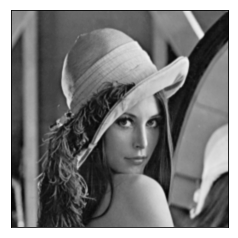

In [93]:
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

In [94]:
class ImgDensity(object):
    def __init__(self, img):
        self.height, self.width = img.shape[:2]
        self.dx = 0.05
        self.dy = 0.05
        self.alpha = 5.0
        self.eps = 0.000000001
        self.x = np.arange(self.width)
        self.y = np.arange(self.height)
        self.xx, self.yy = np.meshgrid(self.y, self.x)
        self.z = img[self.yy, self.xx]
        self.f = interpolate.interp2d(self.x, self.y, self.z, kind='cubic')
        
    def getDensity(self,xp,yp):
        return self.f(xp,yp)
    
    def getLogDensity(self,xp,yp):
        return math.log(max(self.eps, self.getDensity(xp,yp)))
    
    def getGradLogDensity(self,xp,yp):
        #return np.gradient(self.getLogDensity(xp,yp))
        return 0.5*np.array([(self.getLogDensity(xp+self.dx,yp)-self.getLogDensity(xp-self.dx,yp))/self.dx,
                             (self.getLogDensity(xp,yp+self.dy)-self.getLogDensity(xp,yp-self.dy))/self.dy])
    
    def getHessLogDensity(self,xp,yp):
        #return hessian(self.getLogDensity(xp,yp))
        return 0.5*np.array([[(self.getGradLogDensity(xp+self.dx,yp)[0]-self.getGradLogDensity(xp-self.dx,yp)[0])/self.dx,
                             (self.getGradLogDensity(xp,yp+self.dy)[0]-self.getGradLogDensity(xp,yp-self.dy)[0])/self.dx],
                            [(self.getGradLogDensity(xp+self.dx,yp)[1]-self.getGradLogDensity(xp-self.dx,yp)[1])/self.dy,
                             (self.getGradLogDensity(xp,yp+self.dy)[1]-self.getGradLogDensity(xp,yp-self.dy)[1])/self.dy]])
    
    
    def getPreLogDensity(self,xp,yp):
        eigenValues, eigenVector = np.linalg.eig(self.getHessLogDensity(xp,yp))
        eigenBuff = eigenValues;
        for i in range(2):
            eigenBuff[i] = math.tanh(self.alpha*eigenValues[i])/eigenValues[i] if abs(eigenValues[i]) > self.eps else self.alpha
        return np.matmul(np.matmul(eigenVector, np.diag(eigenBuff)), eigenVector.T)

    
    def logProposalDensity(self, x0, x1, y0, y1):
        gradient    = self.getGradLogDensity(x0, x1)
        preCond = self.getPreLogDensity(x0, x1)
        
        return -np.linalg.norm(np.array([y0,y1])-np.array([x0,x1])-0.5*sigmaSq * np.matmul(preCond,gradient.T), ord=2)**2 / (2 * sigmaSq)
        

In [95]:
class MultivariateNormal(object):
    def __init__(self, mean, cov):
        self.mean = mean
        self.cov = cov
        self.dim = mean.size
        
    def getSample(self, width, height):
        y1, y0 = np.random.multivariate_normal(self.mean, self.cov).T
        if (y0 < 0):
            y0 = x0
        if (y0 > width-1):
            y0 = width-1
        if (y1 < 0):
            y1 = 0
        if (y1 > height-1):
            y1 = height-1
        return y1, y0
    
    def plotMultNorm()
    

In [96]:
imgDens = ImgDensity(img)
x0 = 0.5*imgDens.width
x1 = 0.5*imgDens.height
y0 = 0.5*imgDens.width
y1 = 0.5*imgDens.height
print(imgDens.getGradLogDensity(x0, x1))
print(imgDens.getHessLogDensity(x0, x1))
print(imgDens.getPreLogDensity(x0, x1))
print(math.exp(imgDens.logProposalDensity(x0, x1, y0, y1)))

[ 0.15258808 -0.65193015]
[[ 0.70321008  0.16196244]
 [ 0.16196244 -0.63863485]]
[[ 1.38396823 -0.01568153]
 [-0.01568153  1.51388834]]
0.9302812421848198


In [97]:
def makeHistogram(img):
    
    imgDens = ImgDensity(img)
    histogram = np.zeros((imgDens.height, imgDens.width))
    
    x0 = random.randint(0,imgDens.width-1)
    x1 = random.randint(0,imgDens.height-1)
    Fx = imgDens.getLogDensity(x0,x1)
    
    #mean = np.array([x0,x1])
    #cov = sigmaSq*np.identity(2)
    mean = np.array([x0,x1])+0.5*sigmaSq*np.matmul(imgDens.getPreLogDensity(x0, x1),imgDens.getGradLogDensity(x0, x1).T)
    cov = sigmaSq*imgDens.getPreLogDensity(x0, x1)

    A = 0;
    for i in range(mutations):
        gaussian = MultivariateNormal(mean, cov)
        
        y1, y0 = gaussian.getSample(imgDens.width, imgDens.height)
        
        Fy = imgDens.getLogDensity(y0, y1)
        kxy = imgDens.logProposalDensity(x0, x1, y0, y1 )
        kyx = imgDens.logProposalDensity(y0, y1, x0, x1 )
        
        #Axy = min(1, math.exp((Fy) - (Fx )))
        Axy = min(1, math.exp((Fy + kyx) - (Fx + kxy)))
        if (random.uniform(0,1) < Axy):
            A = A + 1
            x0=y0
            x1=y1
            Fx=Fy
            #mean = np.array([x0,x1])
            #cov = sigmaSq*np.identity(2)
            mean = np.array([x0,x1])+0.5*sigmaSq*np.matmul(imgDens.getPreLogDensity(x0, x1),imgDens.getGradLogDensity(x0, x1).T)
            cov = sigmaSq*imgDens.getPreLogDensity(x0, x1)
            
        #histogram[int(round(x1)),int(round(x0))] = histogram[int(round(x1)),int(round(x0))] + 1.0
        histogram[int(round(x1)),int(round(x0))] = 1.0
        if (i%checkpoints) == 0:
            ARate = float(A)/float(i+1)
            print('i: ' + repr(i))
            print('acceptance rate: ' + repr(ARate))
            plt.imshow(histogram, cmap=plt.cm.ocean, interpolation = 'bicubic')
            plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
            plt.show()
    
    ARate = float(A)/float(mutations)
    
    print('acceptance rate: ' + repr(ARate))
    print('histogram max value: ' + repr(histogram.max()))
    histogram =  255 * histogram / histogram.max()
    
    cv2.imwrite("MetropolisTest_Final.png" ,histogram)


i: 0
acceptance rate: 1.0


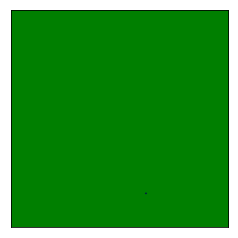

i: 5000
acceptance rate: 0.007998400319936013


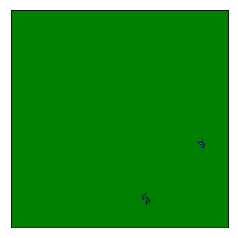

i: 10000
acceptance rate: 0.0045995400459954


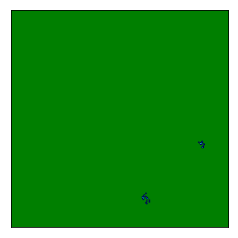

i: 15000
acceptance rate: 0.003999733351109926


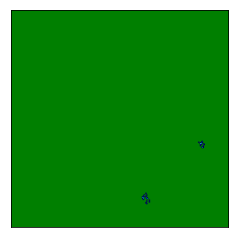

i: 20000
acceptance rate: 0.005249737513124344


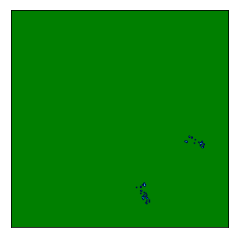

i: 25000
acceptance rate: 0.005919763209471621


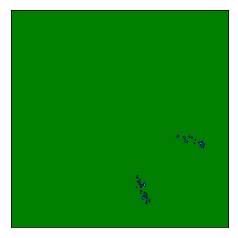

i: 30000
acceptance rate: 0.004933168894370188


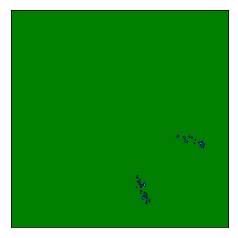

i: 35000
acceptance rate: 0.004228450615696694


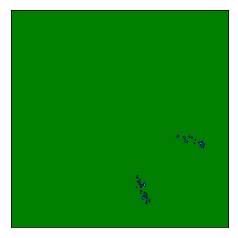

i: 40000
acceptance rate: 0.003699907502312442


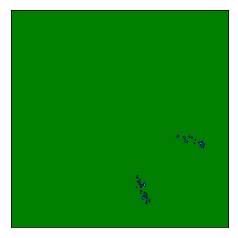

i: 45000
acceptance rate: 0.0032888158040932426


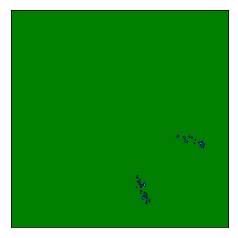

i: 50000
acceptance rate: 0.0029599408011839762


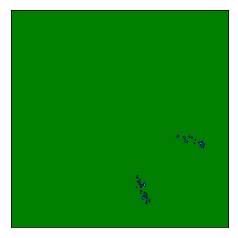

i: 55000
acceptance rate: 0.0026908601661787966


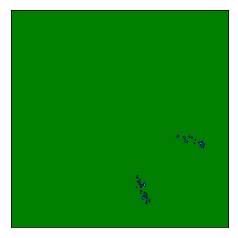

i: 60000
acceptance rate: 0.0024666255562407293


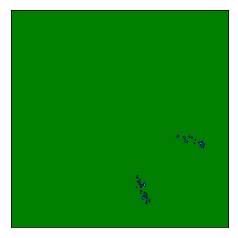

i: 65000
acceptance rate: 0.0022768880478761864


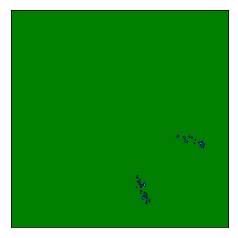

i: 70000
acceptance rate: 0.0021142555106355623


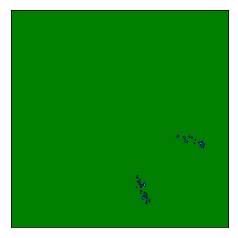

i: 75000
acceptance rate: 0.0019733070225730325


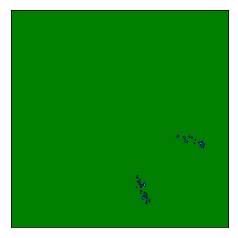

i: 80000
acceptance rate: 0.0018499768752890588


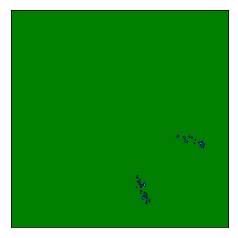

i: 85000
acceptance rate: 0.00174115598640016


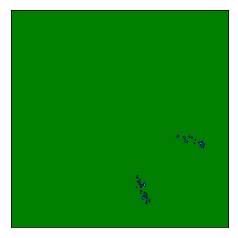

i: 90000
acceptance rate: 0.0016444261730425218


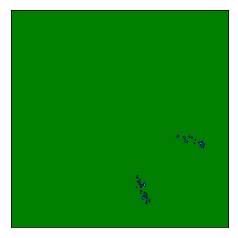

i: 95000
acceptance rate: 0.0015578783381227565


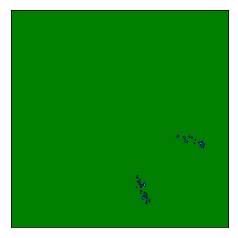

i: 100000
acceptance rate: 0.0014799852001479985


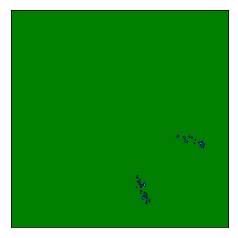

i: 105000
acceptance rate: 0.001409510385615375


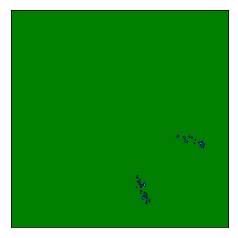

i: 110000
acceptance rate: 0.0013454423141607804


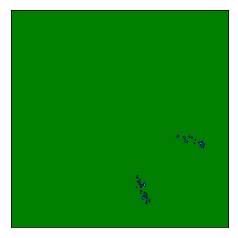

i: 115000
acceptance rate: 0.001286945330910166


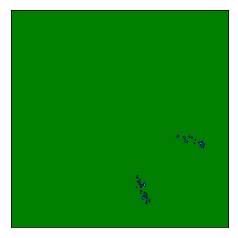

KeyboardInterrupt: 

In [98]:
makeHistogram(img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [ ]:
img_final = cv2.imread('MetropolisTest_Final.png',0)
print('img final max value: ' + repr(img_final.max()))
plt.imshow(img_final, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

In [ ]:
img_error = np.absolute(img - img_final)/img.max()
print('img error max value: ' + repr(img_error.max()))
plt.imshow(img_error, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()